# Hospital Inpatient Discharges (SPARCS De-identified): 2017
Source: New York State Health Department
https://health.data.ny.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/22g3-z7e7

Goal is to predict Risk of Mortality to better inform treatment, aggresivness of approach, expectations of family...

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Using Hospital Inpatient Discharge information for the State of New York from 2017

df= pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017.csv', low_memory= False)

In [3]:
print(df.shape)
df.head()

(2343569, 34)


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Medicare,Self-Pay,NaN,N,N,114168.00,40464.04
1,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,58517.00,26046.50
2,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,...,Moderate,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,39647.04,17397.59
3,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,36031.09,16118.84
4,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,...,Minor,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,30534.00,11921.05


## Exploration of target

**The target that I want to predict is APR Risk of Mortality.**

This is an important target as it will dictate certain decisions such as treatments, aggresiveness of care, familial preparations for the worst outcome etc...
- Ordinal rank Minor(1), Moderate(2), Major(3), Extreme(4)

It is important to determine this metric early on in the process of treating the patient as this is a crucial piece of information in creating efficient and effective treatment plans for higher risk patients.

As such, while doing feature selection we will consider the time frame of when certain features are available in order to implement the model earlier in the inpatient process.

In [4]:
# Ordinal encode
df['APR Risk of Mortality'] = df['APR Risk of Mortality'].replace({
    'Minor': 1,
    "Moderate": 2,
    "Major": 3,
    "Extreme": 4
})

In [5]:
# Target is 'APR Risk of Mortality'

# Look at target statistics
df['APR Risk of Mortality'].describe()

count    2.343329e+06
mean     1.691481e+00
std      9.164827e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: APR Risk of Mortality, dtype: float64

In [6]:
# Value counts

df['APR Risk of Mortality'].value_counts()

1.0    1338452
2.0     508068
3.0     378128
4.0     118681
Name: APR Risk of Mortality, dtype: int64

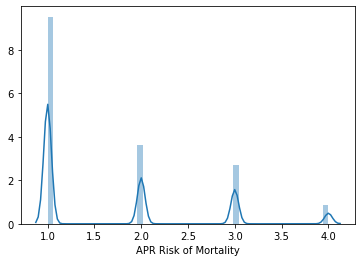

In [7]:
# Visual exploration of the column

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['APR Risk of Mortality']);

My problem is a multi-class classification

In [8]:
# Distribution of target classes

df['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

The majority class (1) for my target is is 57%. <br>
I will use accuracy and average weighted f1 score as my evaluation metrics
- Average f1-scores are used for multi-class targets
- Weighted average f1-score will account for the label inbalance in my target

I will use a random split to train/validate/test my data as all observations are within the same year. <br>

## Feature Exploration

**Features to exclude** <br>
Not applicable to target (Either unique identifier or information gathered at the end of a patients treatment which is not useful as the model needs to be applied earlier)
- Operating Certificate Number (Unique ID for the hospital)
- Patient Disposition (Destination upon discharge)
- Discharge year (The entire dataset is for the year 2017) 
- Total charges (Information not collected until the end of treatment)
- Total cost (Information not collected until the end of treatment)
- Length of stay (only known at the end of treatment)
- Birth weight (only applicable to newborns)


Redundant: All of the codes have a description column. I will pull them out as a reference table, but for my model they are redundant.
- CCS Diagnosis Description
- CCS Procedure Description
- APR DRG Description
- APR MDC Description


Potential data leakage:
- APR Severity of Illness code (Might have a direct correlation to APR Risk of Mortality)
    - Every time there is a 0 for APR Severity of Illness Code, there is a np.nan for APR Risk of Mortality
    - Upon further exploration below, I have decided to omit this column as 60% of the time it is the exact same value as APR Risk of Mortality


Use the below features to create an engineered feature of patient distance to hospital

- Permanent Facility Id
- Facility Name
- Hospital Service Area
- Hospital Country
- Zip code 

## Reference Tables
- Matches descriptions with codes

In [9]:
# Create a reference table for codes and their descriptions
# We will be dropping the descriptions

# CCS Diagnosis
codes_diagnosis = df.groupby('CCS Diagnosis Description')['CCS Diagnosis Code'].mean()
codes_diagnosis = pd.DataFrame(codes_diagnosis)

# CCS Procedure
codes_procedure = df.groupby('CCS Procedure Description')['CCS Procedure Code'].mean()
codes_procedure = pd.DataFrame(codes_procedure)

# APR DRG
codes_drg = df.groupby('APR DRG Description')['APR DRG Code'].mean()
codes_drg = pd.DataFrame(codes_drg)

# APR MDC
codes_mdc = df.groupby('APR MDC Description')['APR MDC Code'].mean()
codes_mdc = pd.DataFrame(codes_mdc)

# APR Severity of Illness
codes_illness = df.groupby('APR Severity of Illness Description')['APR Severity of Illness Code'].mean()
codes_illness = pd.DataFrame(codes_illness)

In [122]:
codes_diagnosis.index.tolist()

['Abdominal hernia',
 'Abdominal pain',
 'Acquired foot deformities',
 'Acute and chronic tonsillitis',
 'Acute and unspecified renal failure',
 'Acute bronchitis',
 'Acute cerebrovascular disease',
 'Acute myocardial infarction',
 'Acute posthemorrhagic anemia',
 'Adjustment disorders',
 'Administrative/social admission',
 'Alcohol-related disorders',
 'Allergic reactions',
 'Anal and rectal conditions',
 'Anxiety disorders',
 'Aortic and peripheral arterial embolism or thrombosis',
 'Aortic; peripheral; and visceral artery aneurysms',
 'Appendicitis and other appendiceal conditions',
 'Aspiration pneumonitis; food/vomitus',
 'Asthma',
 'Attention-deficit, conduct, and disruptive behavior disorders',
 'Bacterial infection; unspecified site',
 'Benign neoplasm of uterus',
 'Biliary tract disease',
 'Birth trauma',
 'Blindness and vision defects',
 'Burns',
 'Calculus of urinary tract',
 'Cancer of bladder',
 'Cancer of bone and connective tissue',
 'Cancer of brain and nervous system',

In [123]:
codes_drg.index.tolist()

['Abdominal pain',
 'Abortion w/o D&C, aspiration curettage or hysterotomy',
 'Acute & subacute endocarditis',
 'Acute Kidney Injury',
 'Acute anxiety & delirium states',
 'Acute leukemia',
 'Acute major eye infections',
 'Acute myocardial infarction',
 'Adjustment disorders & neuroses except depressive diagnoses',
 'Alcohol & drug dependence w rehab or rehab/detox therapy',
 'Alcohol abuse & dependence',
 'Alcoholic liver disease',
 'Allergic reactions',
 'Amputation of lower limb except toes',
 'Anal procedures',
 'Angina pectoris & coronary atherosclerosis',
 'Appendectomy',
 'Asthma',
 'BPD & oth chronic respiratory diseases arising in perinatal period',
 'Bacterial & tuberculous infections of nervous system',
 'Behavioral disorders',
 'Bipolar disorders',
 'Bone marrow transplant',
 'Brain contusion/laceration & complicated skull Fx, coma < 1 hr or no coma',
 'Breast procedures except mastectomy',
 'Bronchiolitis & RSV pneumonia',
 'Burns with skin graft except extensive 3rd degre

## Initial Data Cleaning

In [10]:
# Change pandas display so you can see all of the columns at once

pd.set_option('display.max_columns', 25)

In [11]:
# Drop unnecessary features as commented above

df_cleaned = df.drop([
    'Operating Certificate Number',
    'Patient Disposition',
    'Discharge Year',
    'CCS Diagnosis Description',
    'CCS Procedure Description',
    'APR DRG Description',
    'APR MDC Description',
    'Birth Weight',
    'Total Charges',
    'Total Costs',
    'APR Severity of Illness Description',
    'Length of Stay'
],
    axis= 1

)
df_cleaned.head()

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,Elective,659,0,750,19,2,1.0,Medical,Medicare,Medicare,Self-Pay,N,N
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,Emergency,99,108,194,5,3,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,Emergency,161,102,465,11,2,2.0,Medical,Department of Corrections,Self-Pay,NaN,N,N
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,Emergency,238,222,721,18,2,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,Emergency,2,0,720,18,2,1.0,Medical,Department of Corrections,Self-Pay,NaN,N,N


In [12]:
# Look at null values
df_cleaned.isnull().sum()

Hospital Service Area                  5155
Hospital County                        5155
Permanent Facility Id                  5155
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   39019
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                   240
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   878722
Payment Typology 3                  1737244
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

In [13]:
# Explore missing values in target

missing_illness = df[df['APR Risk of Mortality'].isnull() == True]
missing_illness['Type of Admission'].value_counts(normalize = True)

Newborn      0.745833
Emergency    0.120833
Urgent       0.070833
Elective     0.062500
Name: Type of Admission, dtype: float64

In [14]:
# Drop missing values in target (only 0.01%)
# They were mostly (74.5%) newborn babies which we are not including in our model

df_cleaned.dropna(subset= ['APR Risk of Mortality'], inplace= True)

## Data exploration 

In [15]:
# Look at numeric traits
df_cleaned.describe()

,Permanent Facility Id,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,2.338179e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06
mean,1.038966e+03,1.898662e+02,1.013940e+02,4.161252e+02,1.031172e+01,2.020953e+00,1.691481e+00
std,7.202033e+02,1.649466e+02,8.681344e+01,2.424451e+02,5.899823e+00,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.410000e+02,1.010000e+02,0.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,1.000000e+00
50%,1.097000e+03,1.570000e+02,9.800000e+01,3.830000e+02,9.000000e+00,2.000000e+00,1.000000e+00
75%,1.453000e+03,2.180000e+02,1.800000e+02,6.400000e+02,1.500000e+01,3.000000e+00,2.000000e+00
max,9.431000e+03,2.617000e+03,2.310000e+02,9.520000e+02,2.500000e+01,4.000000e+00,4.000000e+00


In [16]:
# Look at categorical traits
df_cleaned.describe(exclude= 'number')

,Hospital Service Area,Hospital County,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,2338179,2338179,2343329,2343329,2304316,2343329,2343329,2343329,2343329,2343329,2343329,1464708,606295,2343329,2343329
unique,8,57,211,5,50,3,4,4,6,2,10,10,10,2,2
top,New York City,Manhattan,Mount Sinai Hospital,70 or Older,112,F,White,Not Span/Hispanic,Emergency,Medical,Medicare,Medicaid,Self-Pay,N,Y
freq,1070407,395687,52335,664780,293826,1296822,1316956,1895507,1500436,1742545,906899,529653,400972,2339978,1373723


In [17]:
# Look at different label names for spelling mistakes etc...
df_cleaned['Emergency Department Indicator'].value_counts().index.tolist()

['Y', 'N']

In [18]:
# Look at null values, we will need to impute
df_cleaned.isnull().sum()

Hospital Service Area                  5150
Hospital County                        5150
Permanent Facility Id                  5150
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   39013
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   878621
Payment Typology 3                  1737034
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

### Explore relationship between APR Severity of Illness and target for potential data leakage

In [19]:
# Create subset of just the two columns
data_leak = df_cleaned[['APR Severity of Illness Code', 'APR Risk of Mortality']]
data_leak

,APR Severity of Illness Code,APR Risk of Mortality
0,2,1.0
1,3,2.0
2,2,2.0
3,2,2.0
4,2,1.0
...,...,...
2343564,1,2.0
2343565,2,2.0
2343566,1,1.0
2343567,2,1.0


In [20]:
# Look a statistical features
data_leak.describe()

,APR Severity of Illness Code,APR Risk of Mortality
count,2.343329e+06,2.343329e+06
mean,2.020953e+00,1.691481e+00
std,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00
75%,3.000000e+00,2.000000e+00
max,4.000000e+00,4.000000e+00


In [21]:
# Count how many times they are not equivalent

# Convert APR Risk of Mortality to integer
data_leak['APR Risk of Mortality'] = data_leak['APR Risk of Mortality'].astype(int)

# Pull out subset of when the two columns are not equivalent
subset = data_leak[data_leak['APR Risk of Mortality'] != data_leak['APR Severity of Illness Code']]
subset

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,APR Severity of Illness Code,APR Risk of Mortality
0,2,1
1,3,2
4,2,1
6,2,1
10,2,1
...,...,...
2343561,3,2
2343563,2,1
2343564,1,2
2343567,2,1


In [22]:
# Proportion of when these two columns are the same
1 - len(subset) / len(df_cleaned)

0.5913587037927666

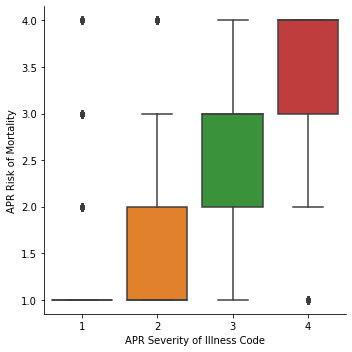

In [23]:
# Visual of relationship
sns.catplot(x= 'APR Severity of Illness Code', y= 'APR Risk of Mortality', kind= 'box', data= data_leak);

**In conclusion I will drop APR Severity of Illness code for two reasons**
- First, it is too similar to the target. 59% of the time they are the exact same value.
- Second, in practice I would want to implement the model before necessarily knowing the severity of the illness. By the time you know the severity of the illness, my model would not provide you with very much additional useful information.

### Explore Redacted Data
- 5150 rows with redacted geographic information
- Labeled 'Redacted for Confidentiality'

In [24]:
# Pull out the redacted information
redacted = df_cleaned[df_cleaned['Facility Name'] == 'Redacted for Confidentiality']
redacted

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
28,NaN,NaN,NaN,Redacted for Confidentiality,0 to 17,NaN,F,White,Not Span/Hispanic,Emergency,229,148,315,8,2,1.0,Surgical,Blue Cross/Blue Shield,Self-Pay,NaN,N,N
595,NaN,NaN,NaN,Redacted for Confidentiality,18 to 29,NaN,F,White,Not Span/Hispanic,Urgent,181,222,564,14,1,1.0,Medical,Blue Cross/Blue Shield,Medicaid,NaN,Y,N
839,NaN,NaN,NaN,Redacted for Confidentiality,18 to 29,NaN,F,Black/African American,Not Span/Hispanic,Emergency,177,127,544,14,1,1.0,Surgical,Medicaid,Medicaid,Self-Pay,Y,N
2227,NaN,NaN,NaN,Redacted for Confidentiality,0 to 17,NaN,F,Other Race,Spanish/Hispanic,Emergency,195,126,560,14,2,1.0,Medical,Medicaid,NaN,NaN,Y,Y
2723,NaN,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,F,Black/African American,Not Span/Hispanic,Emergency,180,123,545,14,1,1.0,Surgical,Medicaid,NaN,NaN,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342722,NaN,NaN,NaN,Redacted for Confidentiality,0 to 17,NaN,M,White,Spanish/Hispanic,Newborn,218,115,640,15,1,1.0,Medical,Medicaid,NaN,NaN,N,N
2342742,NaN,NaN,NaN,Redacted for Confidentiality,70 or Older,NaN,U,White,Not Span/Hispanic,Emergency,99,0,194,5,2,2.0,Medical,Medicare,Medicaid,NaN,N,Y
2342768,NaN,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,M,Black/African American,Not Span/Hispanic,Emergency,83,0,53,1,1,1.0,Medical,Medicaid,NaN,NaN,N,Y
2342862,NaN,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,F,White,Not Span/Hispanic,Emergency,178,127,544,14,2,1.0,Surgical,Medicaid,Medicaid,NaN,Y,Y


In [25]:
# Explore redacted rows
redacted.describe()

,Permanent Facility Id,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,0.0,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,NaN,196.830097,110.588544,526.164854,13.269320,1.726602,1.329903
std,NaN,125.279172,67.198097,158.935758,3.970063,0.755514,0.659645
min,NaN,2.000000,0.000000,4.000000,1.000000,1.000000,1.000000
25%,NaN,177.000000,87.000000,544.000000,14.000000,1.000000,1.000000
50%,NaN,179.000000,126.000000,545.000000,14.000000,2.000000,1.000000
75%,NaN,180.000000,131.000000,564.000000,14.000000,2.000000,1.000000
max,NaN,2617.000000,231.000000,952.000000,25.000000,4.000000,4.000000


In [26]:
redacted.describe(exclude = 'number')

,Hospital Service Area,Hospital County,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,0,0,5150,5150,0,5150,5150,5150,5150,5150,5150,2519,877,5150,5150
unique,0,0,1,5,0,3,4,4,6,2,10,10,7,2,2
top,NaN,NaN,Redacted for Confidentiality,30 to 49,NaN,F,Other Race,Not Span/Hispanic,Emergency,Surgical,Medicaid,Medicaid,Self-Pay,Y,Y
freq,NaN,NaN,5150,2175,NaN,4215,1788,2755,3873,2693,2671,1409,705,3351,3559


In [27]:
# 65% of the redacted information was because they were abortions
# Will drop these rows because abortion indicator has zero effect on my model
redacted['Abortion Edit Indicator'].value_counts(normalize= True)

Y    0.65068
N    0.34932
Name: Abortion Edit Indicator, dtype: float64

In [28]:
# Look at the distribution of various features within redacted subset
# Looking to see if there is a specific reason these were redacted

redacted['APR Severity of Illness Code'].value_counts(normalize= True)

1    0.436505
2    0.423301
3    0.117282
4    0.022913
Name: APR Severity of Illness Code, dtype: float64

Will drop rows with redacted information because 65% are redacted due to being an abortion (abortion indicator has zero impact on my model). The rest maintain a normal distribution throughout the features so I will not be losing any information by dropping them (0.078% of observations). 

In [29]:
# Dropped redacted observations - Where Hospital County is null
df_cleaned.dropna(subset= ['Hospital County'], inplace= True)

In [30]:
# Check that redacted observations were dropped
print(df_cleaned.shape)
df_cleaned.isnull().sum()

(2338179, 22)


Hospital Service Area                     0
Hospital County                           0
Permanent Facility Id                     0
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   33863
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   875990
Payment Typology 3                  1732761
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

### Clean zip code
- I want to replace missing zip codes with the most frequent for the county that the hospital is located in

In [31]:
# Define a function that will take the most frequent 

def manual_mode(X):
    manmode = X.copy()
    try: manmode = manmode.value_counts().index[0]
    except: pass
    return manmode

In [32]:
# Use the previously defined function to fill null values with most frequent zip code grouped by Hospital County

df_cleaned['Zip Code - 3 digits'] = df_cleaned['Zip Code - 3 digits'].fillna(df_cleaned.groupby('Hospital County')['Zip Code - 3 digits'].transform(manual_mode))


In [33]:
df_cleaned.isnull().sum()

Hospital Service Area                     0
Hospital County                           0
Permanent Facility Id                     0
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                       0
Gender                                    0
Race                                      0
Ethnicity                                 0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   875990
Payment Typology 3                  1732761
Abortion Edit Indicator                   0
Emergency Department Indicator            0
dtype: int64

### Clean Payment Typology 2 and 3
- Replace missing values with 'None'
- These patients only used one type of payment, didn't need type 2 or 3

In [34]:
# Replace missing values of Payment Typology 2 and 3 with 'None', they only used one type of payment
df_cleaned['Payment Typology 2']= df_cleaned['Payment Typology 2'].replace({np.nan: 'None'})
df_cleaned['Payment Typology 3']= df_cleaned['Payment Typology 3'].replace({np.nan: 'None'})

In [35]:
# Check which null values are left to clean

df_cleaned.isnull().sum()

Hospital Service Area               0
Hospital County                     0
Permanent Facility Id               0
Facility Name                       0
Age Group                           0
Zip Code - 3 digits                 0
Gender                              0
Race                                0
Ethnicity                           0
Type of Admission                   0
CCS Diagnosis Code                  0
CCS Procedure Code                  0
APR DRG Code                        0
APR MDC Code                        0
APR Severity of Illness Code        0
APR Risk of Mortality               0
APR Medical Surgical Description    0
Payment Typology 1                  0
Payment Typology 2                  0
Payment Typology 3                  0
Abortion Edit Indicator             0
Emergency Department Indicator      0
dtype: int64

## Split into train/val/test using random split

In [36]:
from sklearn.model_selection import train_test_split

# Split train data into train and test, 80/20 split

train, test = train_test_split(df_cleaned, train_size=0.85, test_size=0.15, 
                              stratify=df_cleaned['APR Risk of Mortality'], random_state=42)

# Then split train into train and validate
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['APR Risk of Mortality'], random_state=42)

train.shape, val.shape, test.shape

((1589961, 22), (397491, 22), (350727, 22))

## Baseline model: 
Majority class (1, minor risk) is 57%

In [37]:
df_cleaned['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.570766
2.0    0.216905
3.0    0.161616
4.0    0.050714
Name: APR Risk of Mortality, dtype: float64

In [38]:
# Baseline classification report
from sklearn.metrics import classification_report

# Looking at weighted average f1-score as an evaluation metric 
guess= [1] * len(df_cleaned)

print(classification_report(df_cleaned['APR Risk of Mortality'], guess))

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         1.0       0.57      1.00      0.73   1334553
         2.0       0.00      0.00      0.00    507162
         3.0       0.00      0.00      0.00    377886
         4.0       0.00      0.00      0.00    118578

    accuracy                           0.57   2338179
   macro avg       0.14      0.25      0.18   2338179
weighted avg       0.33      0.57      0.41   2338179



## First Model

In [39]:
# Set features and target
# Define target vector and feature matrices

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [40]:
# Install category encoders in anaconda environment
# conda install -c conda-forge category_encoders

In [41]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline (encode, standardize, model)
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 10, n_estimators= 10)
)

# Fit on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.6783669536548381
Validation Accuracy: 0.6771625017924934


#### First model evaluation metric results (Without feature APR Severity of Illness Code)
Train Accuracy: 0.6816669103706833 <br>
Validation Accuracy: 0.6794078811946803

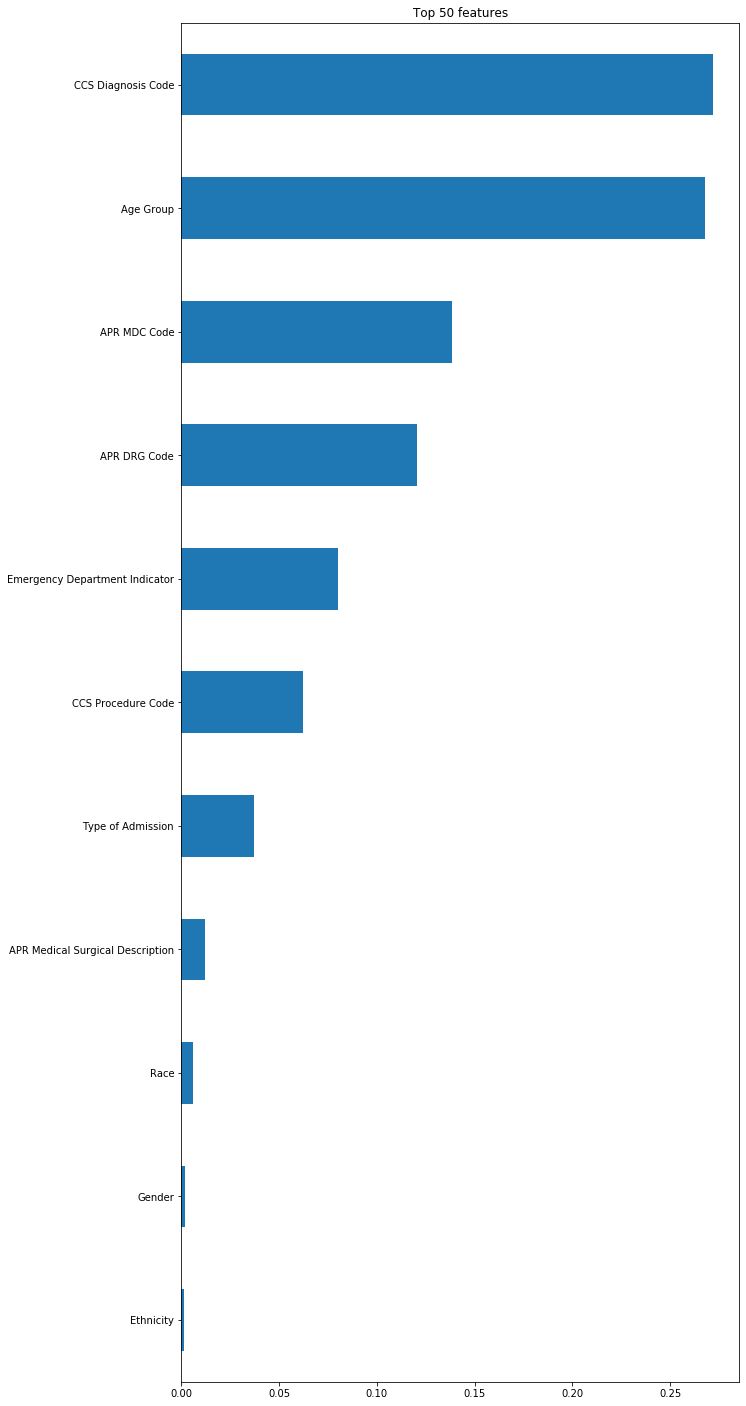

In [42]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

### Confusion Matrix

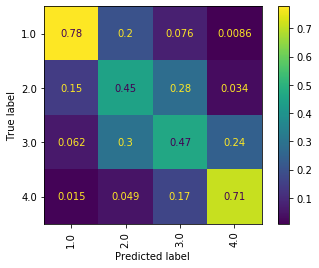

In [43]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix

# Plot
plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation= 'vertical', normalize= 'pred')

# Enlarge
plt.rcParams['figure.dpi']= 200

### Scores for Model 1

In [44]:
# Look at precision and recall for each class
# Using weighted average f1-score as an evaluation metric

from sklearn.metrics import classification_report

# Make predictions
y_pred= pipeline.predict(X_val)

# Print scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.78      0.92      0.84    226874
         2.0       0.45      0.36      0.40     86218
         3.0       0.47      0.41      0.43     64241
         4.0       0.71      0.16      0.26     20158

    accuracy                           0.68    397491
   macro avg       0.60      0.46      0.49    397491
weighted avg       0.65      0.68      0.65    397491



Remember that the baseline model had an accuracy of 57% with a weighted average f1-score of 0.42

## Model 2
- Include all of the features except for geographic data

In [45]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Payment Typology 2',
    'Payment Typology 3',
    'Abortion Edit Indicator',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [46]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.7718975496883257
Validation Accuracy: 0.6925062454244247


### Scores for Model 2

In [47]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.90      0.86    226874
         2.0       0.46      0.42      0.44     86218
         3.0       0.48      0.45      0.47     64241
         4.0       0.61      0.24      0.34     20158

    accuracy                           0.69    397491
   macro avg       0.59      0.50      0.53    397491
weighted avg       0.68      0.69      0.68    397491



Model 2 bumped the evaluation scores up 2-3 points each.

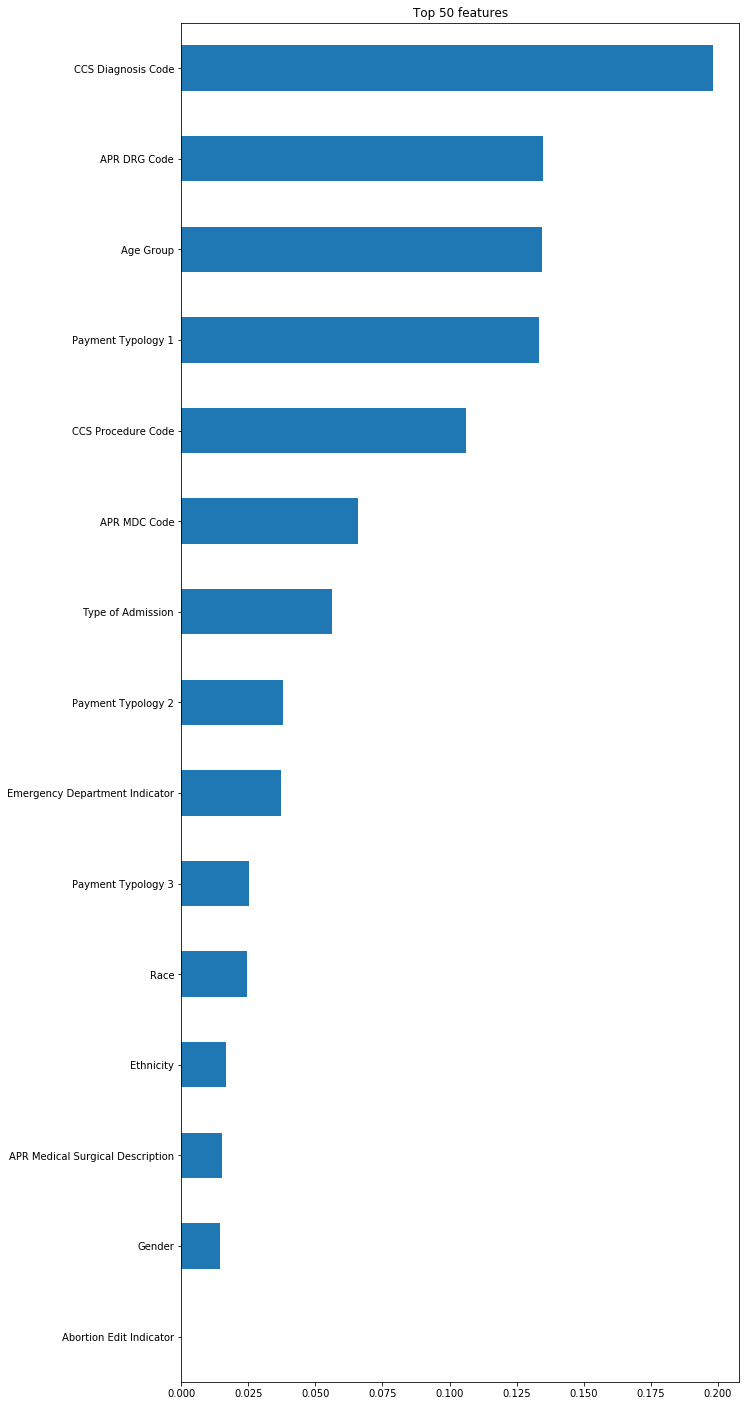

In [48]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

#### Permutation importances

In [49]:
# You can't use a pipeline in eli5
# Need to transform data and fit model before inputting into PermutationImportance

# Create pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the data
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

# Define model with parameters
model = RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)

# Fit the model to train data
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
# Install eli5 on anaconda environment
# conda install -c conda-forge eli5

In [51]:
# Import
import eli5
from eli5.sklearn import PermutationImportance

# Define permuter and parameters
permuter= PermutationImportance(model, scoring= 'accuracy', n_iter= 5, random_state= 42)

# Fit permutation importance to transformed validation data
permuter.fit(X_val_transformed, y_val)

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_frac

In [52]:
# Show weights graphic

# Define feature labels
feature_labels = X_val.columns.tolist()

# Run and print function
eli5.show_weights(permuter, top= None, feature_names= feature_labels)

Weight,Feature
0.0559 ± 0.0006,Age Group
0.0483 ± 0.0016,CCS Diagnosis Code
0.0284 ± 0.0005,APR DRG Code
0.0282 ± 0.0006,CCS Procedure Code
0.0165 ± 0.0003,APR MDC Code
0.0153 ± 0.0006,Payment Typology 1
0.0125 ± 0.0003,APR Medical Surgical Description
0.0086 ± 0.0006,Emergency Department Indicator
0.0080 ± 0.0003,Type of Admission
0.0023 ± 0.0003,Payment Typology 2


In [53]:
# conda install -c conda-forge xgboost

### XGBoost

In [54]:
# # Import
# from xgboost import XGBClassifier

# # Create pipeline using XGBoostClassifier
# pipeline = make_pipeline(
#     ce.OrdinalEncoder(),
#     StandardScaler(),
#     XGBClassifier(n_estimators= 30, random_state= 42, n_jobs= -1)
# )

# # Fit pipeline to train data
# pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# # Import
# from sklearn.metrics import accuracy_score

# # Make predictions
# y_pred= pipeline.predict(X_val)

# # Print error metric
# print('Validation Accuracy', accuracy_score(y_val, y_pred))

In [ ]:
# # Print recall, precision and f1 scores
# print(classification_report(y_val, y_pred))

XGBoost did not improve the evaluation metrics from random forest

## Model 3
- Feature engineer: distance to hospital
- Feature engineer: did they require multiple methods of payment
- Clean up feature selection. Don't include ones that have low importance in the model

In [94]:
train.head()

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
391575,Hudson Valley,Westchester,1097.0,SJRH - St Johns Division,18 to 29,107,F,Black/African American,Not Span/Hispanic,Emergency,125,0,144,4,2,1.0,Medical,Blue Cross/Blue Shield,Self-Pay,Self-Pay,N,Y
1129343,Central NY,Oneida,599.0,Faxton-St Lukes Healthcare St Lukes Division,18 to 29,135,F,Black/African American,Not Span/Hispanic,Elective,184,0,563,14,2,1.0,Medical,Medicare,Medicaid,None,N,N
944206,Hudson Valley,Westchester,1139.0,Westchester Medical Center,70 or Older,105,F,Black/African American,Not Span/Hispanic,Emergency,197,0,383,9,2,1.0,Medical,Medicare,Medicare,None,N,Y
497042,New York City,Bronx,1172.0,Lincoln Medical & Mental Health Center,30 to 49,104,M,Black/African American,Not Span/Hispanic,Emergency,122,0,893,24,2,3.0,Medical,Private Health Insurance,Medicaid,None,N,Y
2282639,New York City,Kings,1318.0,Wyckoff Heights Medical Center,0 to 17,113,M,Other Race,Not Span/Hispanic,Emergency,211,0,351,8,1,1.0,Medical,Medicaid,Miscellaneous/Other,None,N,Y


In [126]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Type of Admission',
    'CCS Procedure Code',
    'CCS Diagnosis Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [127]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.727950559793605
Validation Accuracy: 0.6889791215398587


Scores

In [128]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      0.90      0.86    226874
         2.0       0.46      0.42      0.44     86218
         3.0       0.47      0.45      0.46     64241
         4.0       0.59      0.27      0.37     20158

    accuracy                           0.69    397491
   macro avg       0.58      0.51      0.53    397491
weighted avg       0.67      0.69      0.68    397491



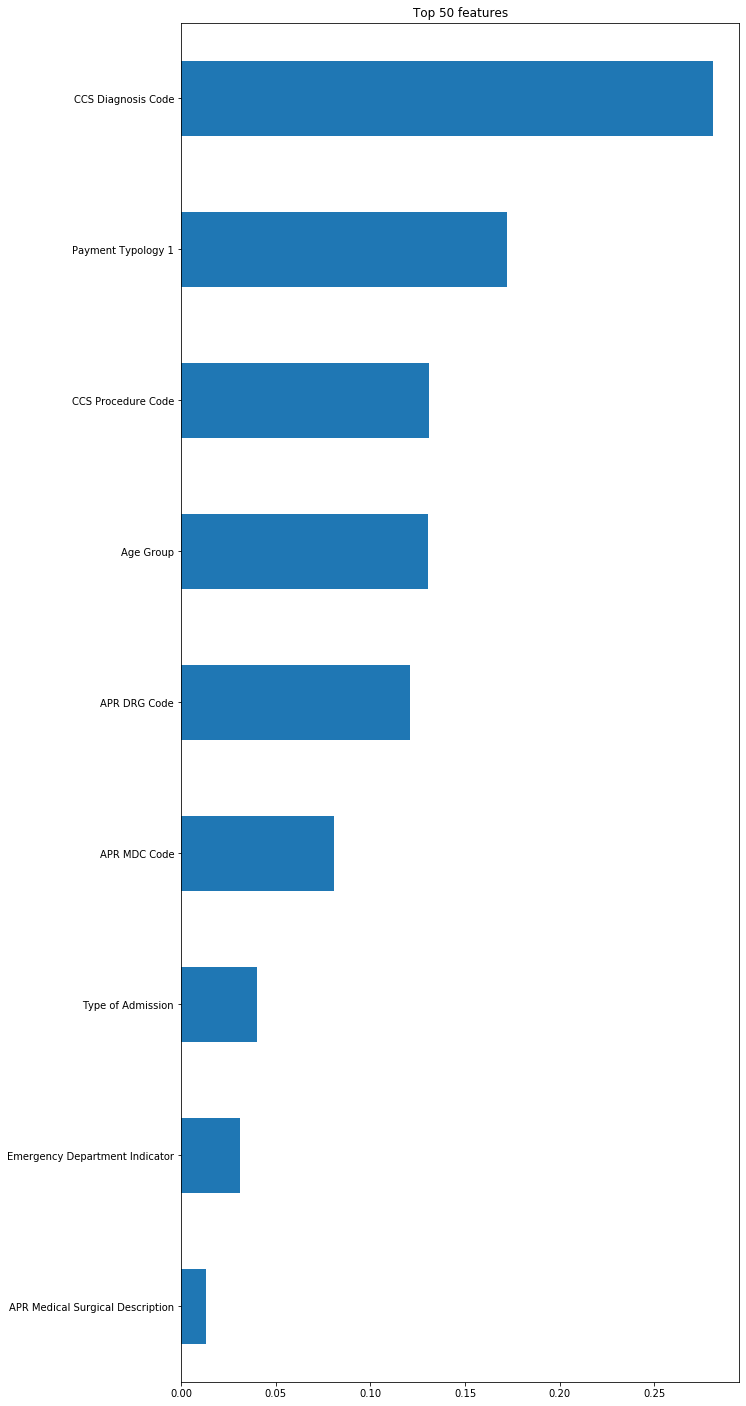

In [58]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [129]:
# You can't use a pipeline in eli5
# Need to transform data and fit model before inputting into PermutationImportance

# Create processor pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the data
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

# Define model with parameters
model = RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)

# Fit the model to train data
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [130]:
# Import
import eli5
from eli5.sklearn import PermutationImportance

# Define permuter and parameters
permuter= PermutationImportance(model, scoring= 'accuracy', n_iter= 5, random_state= 42)

# Fit permutation importance to transformed validation data
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_frac

In [131]:
# Show weights graphic

# Define feature labels
feature_labels = X_val.columns.tolist()

# Run and print function
eli5.show_weights(permuter, top= None, feature_names= feature_labels)

Weight,Feature
0.0944 ± 0.0009,CCS Diagnosis Code
0.0837 ± 0.0010,Age Group
0.0748 ± 0.0007,CCS Procedure Code
0.0445 ± 0.0011,APR Medical Surgical Description
0.0178 ± 0.0006,Type of Admission
0.0156 ± 0.0004,Emergency Department Indicator
0.0147 ± 0.0006,Payment Typology 1


### Linear Classification Model
- Logistic regression
- SVC (Support Vector Classification)

**Support Vector Machine**

In [67]:
# run svm on a smaller sample of data - 10% of tain and val data sets

train_sample = train.sample(frac= .1)
val_sample = val.sample(frac= .1)

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Emergency Department Indicator',
]

X_train_sample= train_sample[features]
y_train_sample= train_sample[target]

X_val_sample= val_sample[features]
y_val_sample= val_sample[target]


In [65]:
# Import Support Vector Machine
from sklearn import svm

In [68]:
# Create processor pipeline to transform data
processor = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the sample data
X_train_transformed = processor.fit_transform(X_train_sample)
X_val_transformed = processor.transform(X_val_sample)

In [69]:
# Instantiate Support Vector Classification
svm = svm.SVC()

# Fit SVC to transformed, sample data
svm.fit(X_train_transformed, y_train_sample, random_state= 42)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
# Make predictions
y_pred= svm.predict(X_val_transformed)

# Print recall, precision and f1 scores
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

         1.0       0.77      0.90      0.83     22704
         2.0       0.41      0.43      0.42      8564
         3.0       0.43      0.24      0.31      6533
         4.0       0.45      0.13      0.20      1948

    accuracy                           0.65     39749
   macro avg       0.52      0.43      0.44     39749
weighted avg       0.62      0.65      0.63     39749



**Logistic Regression Model**

In [63]:
# Import
from sklearn.linear_model import LogisticRegression

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.6020776610243899
Validation Accuracy: 0.6024840814005852


In [64]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.67      0.91      0.77    226874
         2.0       0.36      0.20      0.26     86218
         3.0       0.40      0.24      0.30     64241
         4.0       0.41      0.03      0.05     20158

    accuracy                           0.60    397491
   macro avg       0.46      0.34      0.34    397491
weighted avg       0.54      0.60      0.55    397491



### Partial Dependence Plot - 1 Isolated Variable

In [ ]:
# # Install pdpbox in anaconda environment
# conda install -c conda-forge pdpbox

In [ ]:
# Use Ordinal Encoder, outside of a pipeline, no scaler to increase readabliity

encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [ ]:
# Import Partial Dependence Plot
from pdpbox.pdp import pdp_isolate, pdp_plot

In [ ]:
# Model plot

# Choose feature
feature = 'Age Group'

# Set model
isolated = pdp_isolate(
    model= model,
    dataset= pd.DataFrame(X_val_encoded, columns= X_val.columns),
    model_features= X_val.columns,
    feature = feature
)

# View plot
pdp_plot(isolated, feature);

In [ ]:
# # View plot
# pdp_plot(isolated, feature);

### PDP with Two Interacting Variables

In [ ]:
# Partial Dependence Plot with 2 fetures

# Import
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Define features you want to examine
features = ['Age Group', 'Type of Admission']

# Create Model
interaction = pdp_interact(
    model= model, 
    dataset= pd.DataFrame(X_val_encoded, columns= X_val.columns),
    model_features= X_val.columns,
    features= features
)

# Plot Results
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Shapley Force Plot

In [ ]:
# Install shap in anaconda environment
# conda install -c conda-forge shap

In [ ]:
# Import shap
import shap

In [ ]:
# Pick row of val to examine
row= X_val.iloc[[0]]
row

In [ ]:
# For Minor risk of Mortality class

# Get Shapley values
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

# Plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit' 
)

In [ ]:
# For moderate Risk of Mortality class

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed, check_additivity= False)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit')

In [ ]:
# For major risk of mortality class

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed, check_additivity= False)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2], 
    shap_values=shap_values[2], 
    features=row, 
    link='logit')

In [ ]:
# For extreme risk of mortality class

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed, check_additivity= False)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[3], 
    shap_values=shap_values[3], 
    features=row, 
    link='logit')